# Rev $\Delta \eta_{HH}$ validation

**Goal:** I want to check the **pulls** and post fit distribution here.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import cabinetry
cabinetry.set_logging()

import boost_histogram as bh
import hist
import pyhf
from pyhf.contrib.utils import download

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *


%load_ext autoreload
%autoreload 2

In [65]:
cabinetry.__version__

'0.4.0'

## Open the histogram files

In [2]:
c = 'val1p1'

subDir = 'data161718-MAY21_4b_rev_deta_ggf'

modelDir = f'../gp-for-flows/models/{subDir}'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

nSeeds = 25

yrs = ['16','17','18']

In [3]:
hdict = {yr:{} for yr in yrs} # GP + flow prediction

for yr in yrs:
    with open(f'{modelDir}/{modelConfig}/hists_gp_100k_pipe_{yr}.json','r') as hfile:
        out = json.load(hfile)

    for k in out.keys():
        hdict[yr][k] = np.array( out[k])

In [4]:
hAll = {}

for k in hdict['16'].keys():
    if 'std' in k: 
        continue
        
    hAll[k] = np.vstack([hd[k] for yr,hd in hdict.items()]).sum(axis=0)
    

In [5]:
for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
    k = f'{c}_SR{tag}'
    
    # Correlated errors
    stack = np.vstack([hAll[f'{k}_{i}'] for i in range(nSeeds)])
    hAll[f"{k}_std"] = np.sqrt(np.sum((stack - hAll[f'{k}_mean'])**2, axis=0) / (nSeeds-1))
        

In [6]:
myRanges,edg_3d = get_default_bins(rev_deta=True)

In [7]:
edg_3d[0]

[0, 0.95, 1.6]

<span style="color:blue"> To get the correct `s_hist` plot, would need to have the rev_deta signal files loaded in. </span>

In [8]:
s_cols = ["ntag", "dEta_hh", "pass_vbf_sel", "X_wt_tag", "mc_sf", "m_hh", "X_hh"]

s_hist = np.zeros((len(edg_3d[0])-1, len(edg_3d[1])-1, len(edg_3d[2])-1))

for mc, yr in zip(['a','d','e'], yrs):
    
    with uproot.open(f"../../hh4b/hh4b-resolved-reconstruction/SMNR_pythia_mc16{mc}.root") as f:
        
        dfi = f['sig'].arrays(s_cols, library='pandas')
        
        mi = (dfi.ntag >= 4) & (~dfi.pass_vbf_sel) & (dfi.X_wt_tag > 1.5)
        
        s_hist += np.histogramdd(dfi.loc[mi,d_cols].values,
                                 edg_3d,
                                 weights=get_lumi(yr) * dfi.loc[mi,'mc_sf'].values)[0]
    

**Load in the data to compare**

In [9]:
myVars

['m_hh',
 'm_hh_cor2',
 'dEta_hh',
 'pT_h1',
 'pT_h2',
 'eta_h1',
 'eta_h2',
 'dphi_hh',
 'X_wt_tag']

In [10]:
hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = d_cols + ['ntag','X_wt_tag','pass_vbf_sel'] + hc_vars

In [11]:
yrs = [16,17,18]

In [12]:
fnames = [f'../data/RR/cryptotuples/rev_deta/data_rev_deta_{yr}.root' for yr in yrs]

In [13]:
dfs = []

for fname in fnames:
    with uproot.open(fname) as f:
        dfs.append( f['sig'].arrays(load_cols,library='pd') )

df = pd.concat(dfs)

In [14]:
df['dphi_hh'] = np.arccos(np.cos(df['phi_h1'] - df['phi_h2']))

In [15]:
mask = df.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
h_3d = np.histogramdd(df.loc[mask,d_cols].values,edg_3d)[0].flatten()

In [16]:
h_3d

array([ 28.,  73., 153., 273., 357., 397., 370., 316., 245., 195., 150.,
       115.,  68.,  41.,  93.,   4.,  29.,  54.,  99., 126., 170., 185.,
       213., 201., 168., 145., 100., 111.,  73., 134.,   1.,   5.,  21.,
        36.,  57.,  76., 102., 122., 102., 103.,  99.,  70.,  60.,  61.,
       108.,  47., 130., 310., 501., 662., 710., 664., 554., 459., 374.,
       246., 177., 135., 100., 175.,   8.,  47.,  79., 157., 262., 354.,
       339., 408., 372., 333., 267., 202., 143.,  96., 262.,   1.,   5.,
        19.,  59., 108., 135., 173., 219., 202., 206., 175., 142., 108.,
        86., 193.])

In [17]:
figDir = 'figures/data161718-MAY21_4b_rev_deta_ggf'

**Show the pre-fit as a ratio plot**

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


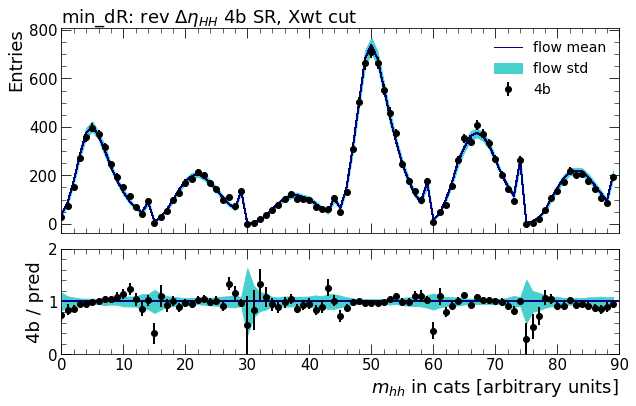

In [18]:
k = '_SR_Xwt_cut'
nom = hAll[f'X_hh_dEta_hh_m_hh{k}_mean']
std = hAll[f'X_hh_dEta_hh_m_hh{k}_std']

fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})

ax1.plot(nom,color='navy',label='flow mean',lw=1)   

ax1.fill_between(range(len(nom)),nom+std,nom-std,color='mediumturquoise',label='flow std')
ax1.errorbar(range(len(nom)), h_3d, np.sqrt(h_3d), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,90)
ax2.set_ylim(0,2)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_3d/nom, np.sqrt(h_3d)/nom, 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')


plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
plt.show()

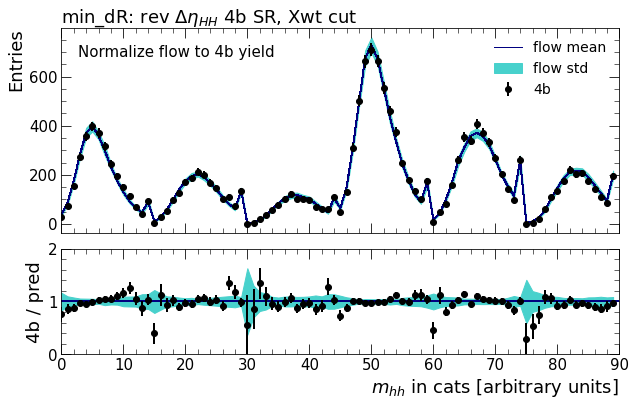

In [19]:
k = '_SR_Xwt_cut'
nom = hAll[f'X_hh_dEta_hh_m_hh{k}_mean']
std = hAll[f'X_hh_dEta_hh_m_hh{k}_std']

s = np.sum(h_3d) / np.sum(nom)


fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})

ax1.plot(s*nom,color='navy',label='flow mean',lw=1)   

ax1.fill_between(range(len(nom)),s*(nom+std),s*(nom-std),color='mediumturquoise',label='flow std')
ax1.errorbar(range(len(nom)), h_3d, np.sqrt(h_3d), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,90)
ax2.set_ylim(0,2)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_3d/(s*nom), np.sqrt(h_3d)/(s*nom), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax1.text(.03,.92,"Normalize flow to 4b yield", 
         va='top', transform=ax1.transAxes)

plt.savefig(f'{figDir}/m_hh_cats_normCorr.pdf',bbox_inches='tight')
plt.show()

In [20]:
figDir

'figures/data161718-MAY21_4b_rev_deta_ggf'

<ipython-input-21-27353b536390>:31: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(xx,1+std/nom,1-std/nom,
<ipython-input-21-27353b536390>:37: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


(50,)


(55,)


<ipython-input-21-27353b536390>:37: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],


(50,)


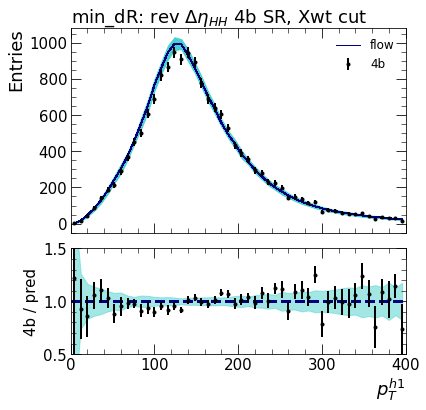

(50,)


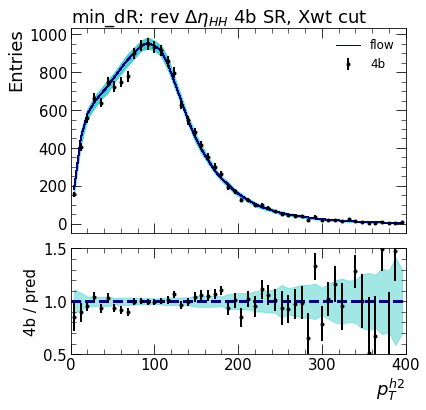

(50,)


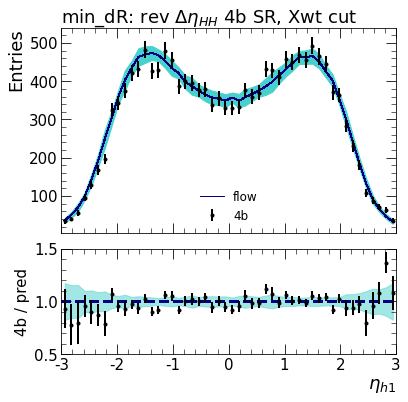

(50,)


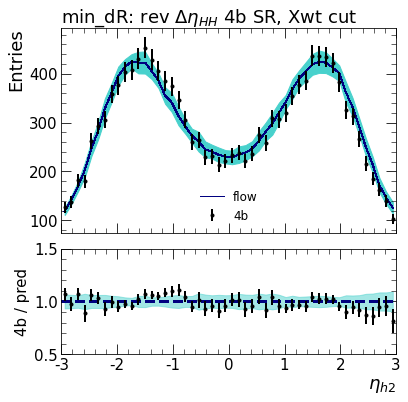

(50,)


<ipython-input-21-27353b536390>:37: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],


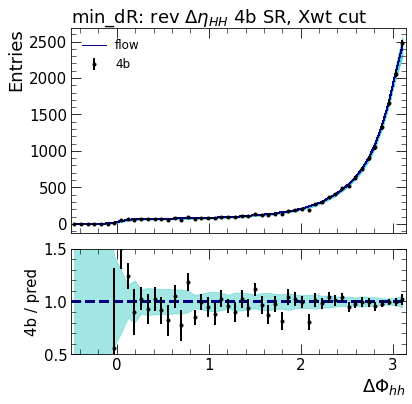

(50,)


<ipython-input-21-27353b536390>:31: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(xx,1+std/nom,1-std/nom,


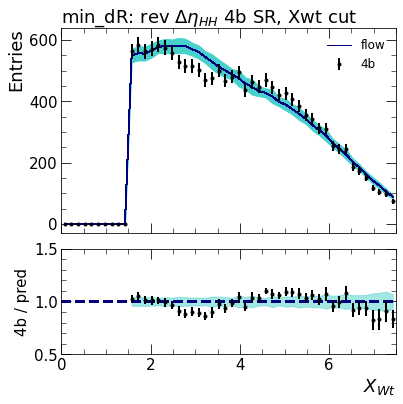

In [21]:
tag = '_SR_Xwt_cut'
hd=hAll

for c, nb, r, xl in zip(myVars, bis, myRanges, varLabels):

    if c == 'm_hh_cor2': 
        continue
    
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":.1})

    e = np.linspace(*r,nb+1)
    xx = 0.5 * (e[1:] + e[:-1])

    h_2b = np.histogram(df.loc[mask,c].values,nb,r)[0]
    print(h_2b.shape)
    ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                 elinewidth=2,marker='.',label='4b',zorder=5)

    
    ax2.plot(e[[0,-1]],[1]*2,'navy',ls='--')

    nom = hd[f'{c}{tag}_mean']
    std = hd[f'{c}{tag}_std']

    ax1.fill_between(xx,nom+std,nom-std,color='mediumturquoise',)
    ax1.plot(xx,nom,color='navy',lw=1,label='flow')           

    
    ax2.fill_between(xx,1+std/nom,1-std/nom,
                     color='mediumturquoise',alpha=.5,zorder=0)
    
    m = nom != 0
    ax2.errorbar(xx[m],
                 h_2b[m]/nom[m],
                 std[m]/h_2b[m],
                 color='k',marker='.',lw=0,elinewidth=2)           

    ax2.set_xlabel(xl,x=1,ha='right',fontsize=18)
    ax2.set_ylabel('4b / pred')
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')

    ax1.legend(fontsize=12)
    ax1.set_xlim(e[[0,-1]])
    ax2.set_ylim(0.5,1.5)

    plt.savefig(f'{figDir}/{c}{tag}.pdf',bbox_inches='tight')
    
    plt.show()

Is it just a norm I can fit?

(50,)


<ipython-input-22-b030a1aa0d27>:36: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(xx,1+std/nom,1-std/nom,
<ipython-input-22-b030a1aa0d27>:42: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],


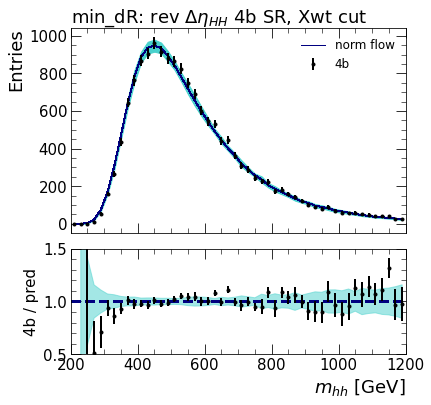

(55,)


<ipython-input-22-b030a1aa0d27>:42: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],


(50,)


(50,)


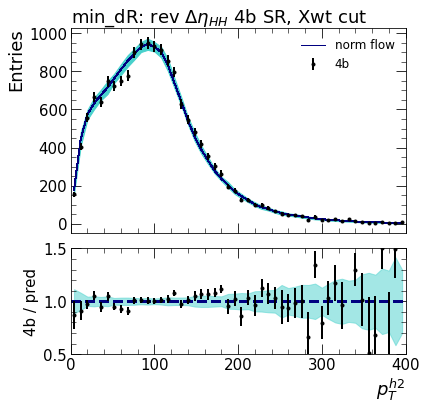

(50,)


(50,)


(50,)


<ipython-input-22-b030a1aa0d27>:42: RuntimeWarning: divide by zero encountered in true_divide
  std[m]/h_2b[m],


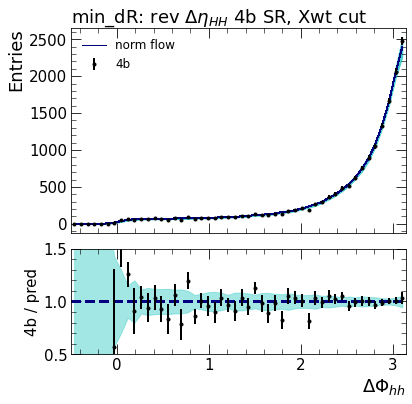

(50,)


<ipython-input-22-b030a1aa0d27>:36: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(xx,1+std/nom,1-std/nom,


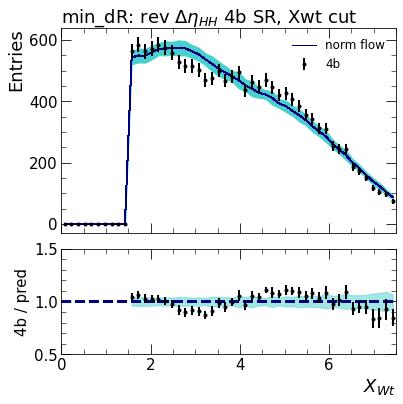

In [22]:
tag = '_SR_Xwt_cut'
hd=hAll

for c, nb, r, xl in zip(myVars, bis, myRanges, varLabels):

    if c == 'm_hh_cor2': 
        continue
    
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":.1})

    e = np.linspace(*r,nb+1)
    xx = 0.5 * (e[1:] + e[:-1])

    h_2b = np.histogram(df.loc[mask,c].values,nb,r)[0]
    print(h_2b.shape)
    ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                 elinewidth=2,marker='.',label='4b',zorder=5)

    
    ax2.plot(e[[0,-1]],[1]*2,'navy',ls='--')

    nom = hd[f'{c}{tag}_mean']
    std = hd[f'{c}{tag}_std']

    
    s = np.sum(h_2b) / np.sum(nom)
    nom *= s
    std *= s
    
    ax1.fill_between(xx,nom+std,nom-std,color='mediumturquoise',)
    ax1.plot(xx,nom,color='navy',lw=1,label='norm flow')           

    
    ax2.fill_between(xx,1+std/nom,1-std/nom,
                     color='mediumturquoise',alpha=.5,zorder=0)
    
    m = nom != 0
    ax2.errorbar(xx[m],
                 h_2b[m]/nom[m],
                 std[m]/h_2b[m],
                 color='k',marker='.',lw=0,elinewidth=2)           

    ax2.set_xlabel(xl,x=1,ha='right',fontsize=18)
    ax2.set_ylabel('4b / pred')
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')

    ax1.legend(fontsize=12)
    ax1.set_xlim(e[[0,-1]])
    ax2.set_ylim(0.5,1.5)

    #plt.savefig(f'figures/{subDir}/trainYrComb/{c}_{tag}.pdf',bbox_inches='tight')
    
    plt.savefig(f'{figDir}/{c}_{tag}_normCorr.pdf',bbox_inches='tight')
    
    plt.show()

Ok - so this is _not_ as great as we were seeing with the 1% 2b dataset, but I _think_ it's really not bad!!

## Check the 3d discriminant in the CR ad VR

In [23]:
crs = []

for fname in fnames:
    with uproot.open(fname) as f:
        crs.append( f['control'].arrays(load_cols[:6],library='pd') )

cr = pd.concat(crs)

In [24]:
nom

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 542.5072315 , 549.46258733,
       548.36907587, 559.01479195, 570.36104493, 572.60097014,
       572.30903348, 574.28510525, 572.98942181, 562.97687805,
       553.53878079, 537.25655459, 522.21251014, 506.15884077,
       493.58335934, 481.55125934, 468.43887617, 452.02507905,
       440.53374441, 427.77975169, 421.9639245 , 410.8754071 ,
       392.90778191, 384.27728173, 369.23686602, 354.63320141,
       338.73288153, 317.84110489, 301.78310658, 285.84389297,
       260.91934529, 242.63763305, 224.56533191, 199.44064792,
       181.95792764, 159.53229474, 139.92634994, 123.52253142,
       103.84582462,  87.60176822])

In [25]:
np.vstack([hAll[f'dEta_hh_m_hh_CR_Xwt_cut_{i}'] for i in range(nSeeds)]).shape

(25, 45)

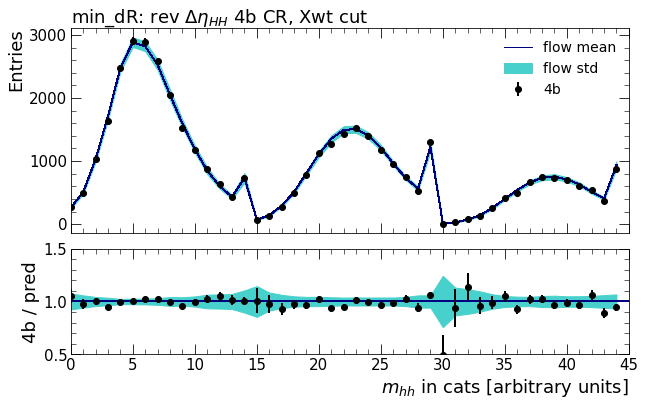

In [26]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
nom = hAll['dEta_hh_m_hh_CR_Xwt_cut_mean']

h_list = np.vstack([hAll[f'dEta_hh_m_hh_CR_Xwt_cut_{i}'] for i in range(nSeeds)])
std = np.std(h_list,axis=0)

m_CR = cr.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
h_cr = np.histogramdd(cr.loc[m_CR,d_cols[1:]].values,edg_3d[1:])[0].flatten()


ax1.plot(nom,color='navy',label='flow mean',lw=1)  

ax1.fill_between(range(len(nom)),nom+std,nom-std,color='mediumturquoise',
                 label='flow std')
ax1.errorbar(range(len(nom)), h_cr, np.sqrt(h_cr), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b CR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,45)
ax2.set_ylim(0.5,1.5)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_cr/(nom), np.sqrt(h_cr)/(nom), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')


plt.savefig(f'{figDir}/m_hh_cats_CR.pdf',bbox_inches='tight')

plt.show()

In [27]:
vrs = []

for fname in fnames:
    with uproot.open(fname) as f:
        vrs.append( f['validation'].arrays(load_cols[:6],library='pd') )

vr = pd.concat(vrs)

In [28]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
nom = hAll['dEta_hh_m_hh_VR_Xwt_cut_mean']

h_list = np.vstack([hAll[f'dEta_hh_m_hh_VR_Xwt_cut_{i}'] for i in range(nSeeds)])
std = np.std(h_list,axis=0)

m_VR = vr.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
h_vr = np.histogramdd(vr.loc[m_VR,d_cols[1:]].values,edg_3d[1:])[0].flatten()

ax1.plot(nom,color='navy',label='flow mean',lw=1)  

ax1.fill_between(range(len(nom)),nom+std,nom-std,color='mediumturquoise',
                 label='flow std')
ax1.errorbar(range(len(nom)), h_vr, np.sqrt(h_vr), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b CR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,45)
ax2.set_ylim(0.5,1.5)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_vr/(nom), np.sqrt(h_vr)/(nom), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')


plt.savefig(f'{figDir}/m_hh_cats_VR.pdf',bbox_inches='tight')

plt.show()

In [29]:
?cabinetry.fit.fit

In [30]:
nom = hAll['X_hh_dEta_hh_m_hh_SR_Xwt_cut_mean']

h_stack = np.stack([ hAll[f'X_hh_dEta_hh_m_hh_SR_Xwt_cut_{i}'] for i in range(25) ], axis=0)
lmbda, u = getEigenvariations(h_stack)

norm = nom.sum()
norm


16315.732242753367

In [31]:
ws_in = {
            "channels": [
                { "name": "ggF_chan",
                  "samples": [
                    { "name": "sig",
                      "data": list(s_hist.flatten()),
                      "modifiers": [ { "name": "mu", 
                                       "type": "normfactor", 
                                       "data": None ,
#                                        "inits": [0], 
#                                        "fixed": True
                                     } ]
                    },
                    { "name": "bkg",
                      "data": list(nom),
                      "modifiers": [ { "name": f"eig{i}", 
                                       "type": "histosys", 
                                       "data": {'hi_data': list( nom + norm * np.sqrt(lmbda[i]) * u[:,i] ),
                                                'lo_data': list( nom - norm * np.sqrt(lmbda[i]) * u[:,i] )
                                               } 
                                     }
                                     for i in range(nSeeds-1)
                                   ]
                    }
                  ]
                }
            ],
            "observations": [
                { "name": "ggF_chan", "data": list(h_3d) }
            ],
            "measurements": [
                { "name": "Measurement", "config": {"poi": "mu", "parameters": []} }
            ],
            "version": "1.0.0"
        }

In [32]:
ws = pyhf.Workspace(ws_in)

INFO - pyhf.workspace - Validating spec against schema: workspace.json


In [33]:
model, data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig0 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig1 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig2 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig3 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig4 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig5 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig6 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig7 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig8 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig9 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig10 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier eig11 (1 new nuisance parameter

In [34]:
?cabinetry.model_utils.model_and_data

In [35]:
from cabinetry.fit import FitResults

In [68]:
labels

['mu',
 'eig0',
 'eig1',
 'eig2',
 'eig3',
 'eig4',
 'eig5',
 'eig6',
 'eig7',
 'eig8',
 'eig9',
 'eig10',
 'eig11',
 'eig12',
 'eig13',
 'eig14',
 'eig15',
 'eig16',
 'eig17',
 'eig18',
 'eig19',
 'eig20',
 'eig21',
 'eig22',
 'eig23']

In [67]:
pyhf.infer.mle.fixed_poi_fit

<function pyhf.infer.mle.fixed_poi_fit(poi_val, data, pdf, init_pars=None, par_bounds=None, fixed_params=None, **kwargs)>

In [82]:
result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fixed_poi_fit(
    0, 
    data, 
    model,
    #fixed_params='mu',
    return_uncertainties=True,
    return_correlations=True,
    return_fitted_val=True,
    return_result_obj=True,
    )

bestfit = pyhf.tensorlib.to_numpy(result[:,0])
uncertainty = pyhf.tensorlib.to_numpy(result[:,0])
labels = model.config.par_names()
corr_mat = pyhf.tensorlib.to_numpy(corr_mat)
best_twice_nll = float(best_twice_nll)  # convert 0-dim np.ndarray to float

best_fit = FitResults(
        bestfit,
        uncertainty,
        labels,
        corr_mat,
        best_twice_nll,
        goodness_of_fit=best_twice_nll
    )

In [87]:
result[0]

array([0., 0.])

In [88]:
# best_fit = cabinetry.fit.fit(model, data)

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
DEBUG - cabinetry.visualize.utils - saving figure as figures/data161718-MAY21_4b_rev_deta_ggf/pulls.pdf
WARNING - fontTools.ttLib.tables._h_e_a_d - 'created' timestamp seems very low; regarding as unix timestamp
WARNING - fontTools.ttLib.tables._h_e_a_d - 'modified' timestamp seems very low; regarding as unix timestamp


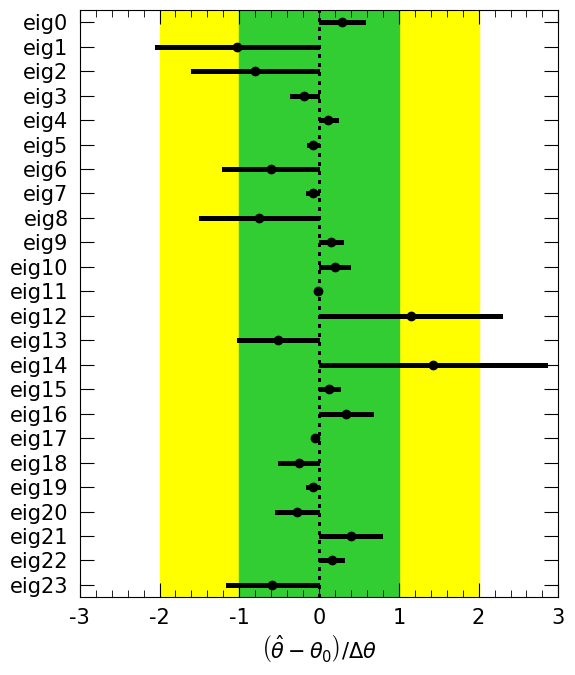

In [89]:
#best_fit = cabinetry.fit.fit(model, data) - this does the S+B fit, + I wat the B-oly fit

cabinetry.visualize.pulls(best_fit,figure_folder=f'figures/{subDir}/',
                          #exclude='mu'
                         )

DEBUG - cabinetry.visualize.utils - saving figure as figures/data161718-MAY21_4b_rev_deta_ggf/correlation_matrix.pdf


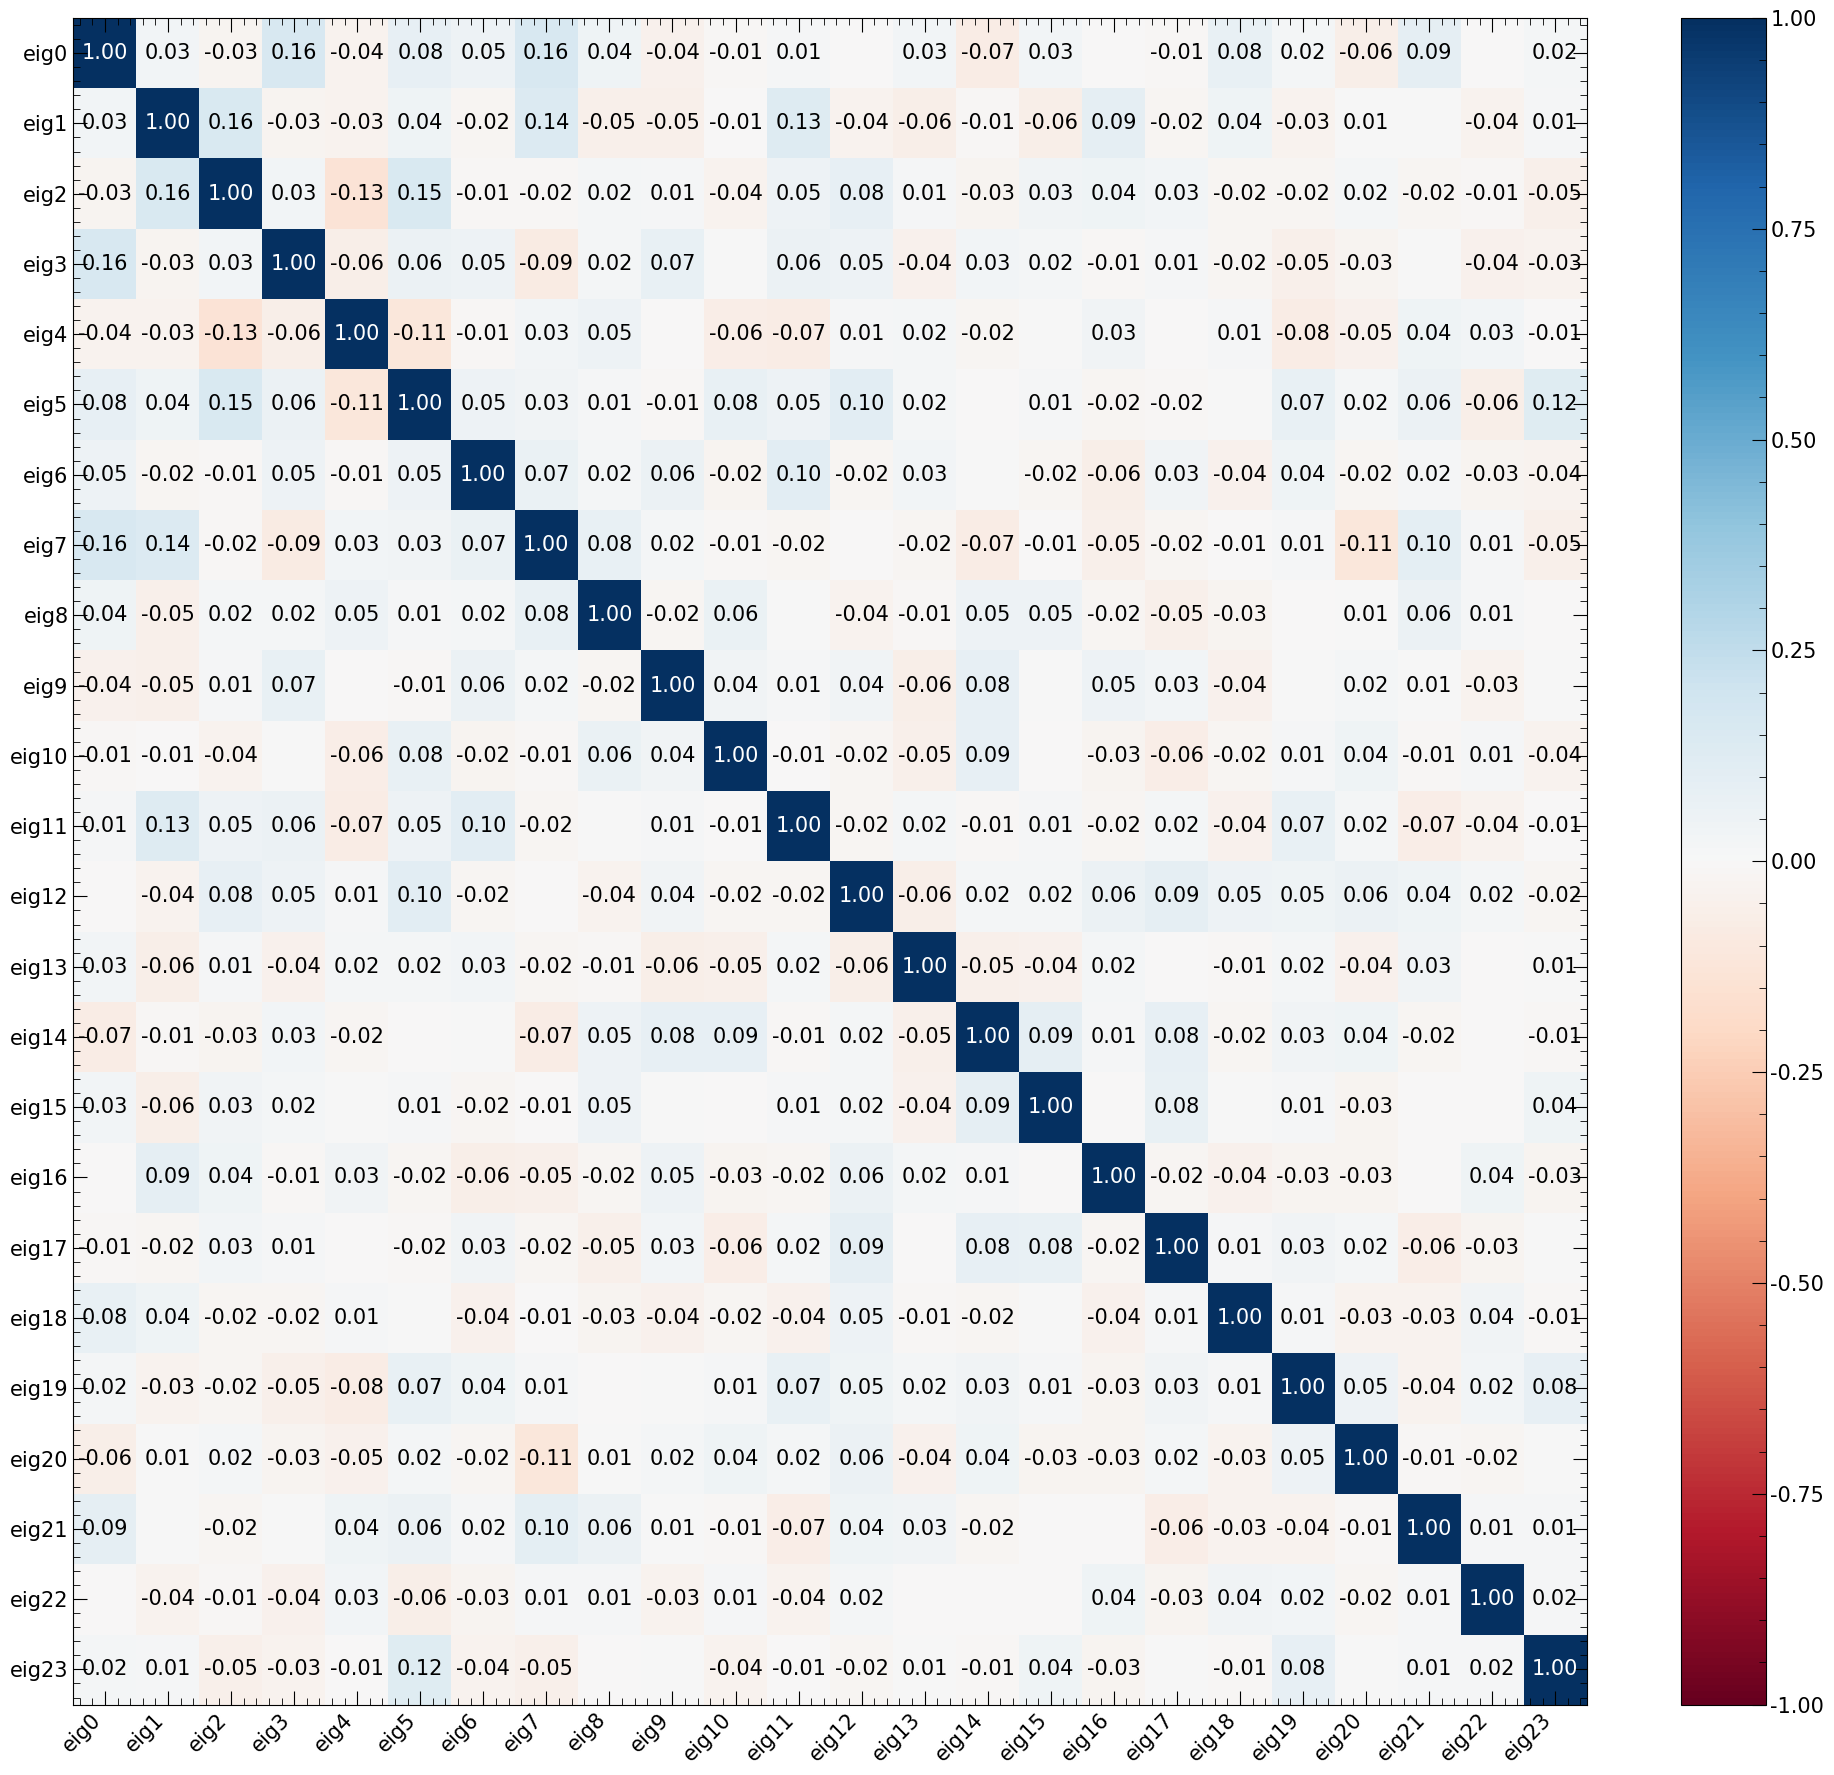

In [90]:
cabinetry.visualize.correlation_matrix(best_fit,
                                       figure_folder=f'figures/{subDir}/')

In [91]:
postfit = cabinetry.model_utils.prediction(model,
                                           label='rev deta postfit', 
                                           fit_results=best_fit)

DEBUG - cabinetry.model_utils - total stdev is [... 1.86, 2.93, 5.54, 4.42, 4.43, 6.54, 7.61, 5.85, 6.37, 6.07, 5.15, 4.13, 10.1]]
DEBUG - cabinetry.model_utils - total stdev per channel is [1.62e-11]


DEBUG - cabinetry.visualize.utils - saving figure as figures/ggF_chan_prefit_log.pdf


[{'figure': <Figure size 432x432 with 2 Axes>, 'region': 'ggF_chan'}]

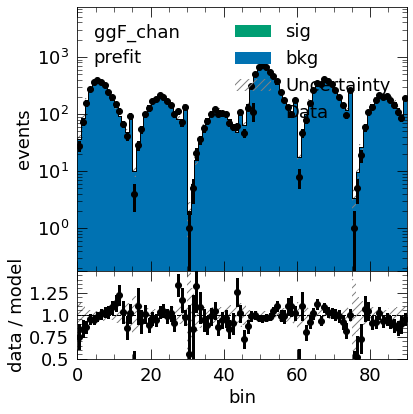

In [92]:
cabinetry.visualize.data_mc(cabinetry.model_utils.prediction(model,label='prefit'),data)

In [93]:
cabinetry.visualize.data_mc(postfit,data)

DEBUG - cabinetry.visualize.utils - saving figure as figures/ggF_chan_rev deta postfit_log.pdf


[{'figure': <Figure size 432x432 with 2 Axes>, 'region': 'ggF_chan'}]

In [94]:
len(postfit.total_stdev_model_bins[0])

90

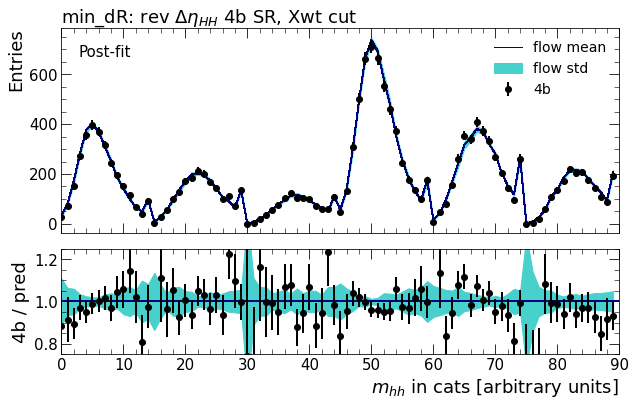

In [98]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
n = np.array(postfit.model_yields[0][0])
s = np.array(postfit.total_stdev_model_bins[0])


ax1.plot(n,color='navy',label='flow mean',lw=1)  

ax1.fill_between(range(len(n)),n+s,n-s,color='mediumturquoise',label='flow std')
ax1.errorbar(range(len(n)), h_3d, np.sqrt(h_3d), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,90)
ax2.set_ylim(0.75,1.25)

ax2.fill_between(range(len(n)),1+s/n,1-s/n,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(n)), h_3d/(n), np.sqrt(h_3d)/(n), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax1.text(.03,.92,"Post-fit", 
         va='top', transform=ax1.transAxes)

plt.savefig(f'{figDir}/m_hh_cats_postfit.pdf',bbox_inches='tight')
plt.show()

**nice!...** This looks great!